# <center> DISPLAY NET WORTH OVER TIME</center>


![image-3.png](attachment:image-3.png)



</br>



<center> net worth by day = CAD + (BTC * rate) + (ETH * rate) </center>



    
---



## RESOURCES

<br/>


### (1) Transactions history API: debits, credits, conversions

- https://shakepay.github.io/programming-exercise/web/transaction_history.json 

- Dates: `04-20-2020` to `01-17-2018`

- Example data:


<br/>

```json
{
    "createdAt": "2020-22-07T03:07:52.330Z",
    "amount": 5,
    "currency": "CAD",
    "type": "conversion",
    "direction": null,
    "to": {
        "currency": "BTC",
        "amount": 0.00038096
    }
},
{
    "createdAt": "2018-01-17T18:23:26.696Z",
    "amount": 5.21,
    "currency": "CAD",
    "type": "peer",
    "direction": "credit",
}
```

<br/>


### (2)  BTC / CAD Conversion rates API

- https://shakepay.github.io/programming-exercise/web/rates_CAD_BTC.json

- Dates: `01-01-2018`  to  `04-22-2020` 

- Example data:

<br/>

```json
{
    "pair": "CAD_BTC",
    "midMarketRate": 17678.38333333333,
    "createdAt": "2018-01-01T00:00:00.000Z"
},
{
    "pair": "CAD_BTC",
    "midMarketRate": 8998.290958547408,
    "createdAt": "2020-04-22T00:00:01.155Z"
}
```

<br/>


### (3) ETH / CAD Conversion rates API

- https://shakepay.github.io/programming-exercise/web/rates_CAD_ETH.json

- Dates: `07-13-2018` to `04-22-2020`

- Example data:

<br/>

```json
{
    "pair": "CAD_ETH",
    "midMarketRate": 576.0677778268919,
    "createdAt": "2018-07-13T03:41:00.000Z"
},
{
    "pair": "CAD_ETH",
    "midMarketRate": 224.5528634739765,
    "createdAt": "2020-04-22T00:00:01.155Z"
}
```

<br/>



[Full instructions](https://shakepay.github.io/programming-exercise/web)


-------


# <center> SOLUTION </center>


### Step 1: Get daily rates

Create a dictionary with the CAD/BTC and CAD/ETH exchange rates by date:
```json
{
    'BTC': {'2018-01-01': 17678.38333333333, date2: rate2, ...},
    'ETH': {'2018-01-17': 576.0677778268919, date2: rate2, ...}
}
```

Then create a function to look up the daily rate for any transaction: `get_date(currency, date)` 


            

In [ ]:
import requests as requests
import matplotlib.pyplot as plt

In [ ]:
btc_rates = requests.get("https://shakepay.github.io/programming-exercise/web/rates_CAD_BTC.json").json()

In [ ]:
eth_rates = requests.get("https://shakepay.github.io/programming-exercise/web/rates_CAD_ETH.json").json()

In [ ]:
rates = {
    'ETH': {rate['createdAt'][:10]: rate['midMarketRate'] for rate in eth_rates},
    'BTC': {rate['createdAt'][:10]: rate['midMarketRate'] for rate in btc_rates},
}

In [ ]:
btc_dates = list(rates['BTC'].keys())
eth_dates = list(rates['ETH'].keys())

In [ ]:
def get_rate(currency, date):

    try:
        return rates[currency][date]

    
    # if rate doesn't exist for a transaction's date, then return the next rate
    except KeyError:

        if currency == 'BTC':
            lst = list(rates['BTC'].keys())
            lst.append(date)
            tmr_index = sorted(lst).index(date) + 1
            date =  btc_dates[tmr_index]
            return rates['BTC'][date]
        
        if currency == 'ETH':
            lst = list(rates['ETH'].keys())
            lst.append(date)
            srted_lst = sorted(lst)
            tmr_index = srted_lst.index(date) + 1
            date = eth_dates[tmr_index]
            return rates['ETH'][date]



-----

### Step 2: Track the balance after every transaction



Iterate through transaction history dictionaries.
- create a global `balance` dictionary, then upate it after every transaction
- calculate daily net worth, then store it in a global `net_worth_by_day` dictionary


In [ ]:
data = requests.get("https://shakepay.github.io/programming-exercise/web/transaction_history.json").json()

In [ ]:
transactions = sorted(data, key=lambda d: d['createdAt'])

In [ ]:
def calculate_net_worth(transactions):
    
    balance = {
        "CAD": 0,
        "BTC": 0,
        "ETH": 0
    }

    net_worth_by_day = {}

    for txn in transactions:
        
        # create variables, make more readable for dict calculations
        currency = txn['currency'] 
        amount = txn['amount']
        date = txn['createdAt'][:10]

        
        # subtract debits, add credits 
        if txn['direction'] == 'debit':
            balance[currency] -= amount

        if txn['direction'] == 'credit':
            balance[currency] += amount

        # handle conversions
        if txn['direction'] is None:

            # subtract before-conversion amounts
            balance[currency] -= amount

            # add after-conversion amounts
            to_currency = txn['to']['currency']
            to_amount = txn['to']['amount']
            balance[to_currency] += to_amount

        # update global balance
        txn['balance'] = balance

        # calculate net balance with relevant rates
        net = (
                balance['CAD'] +
                (balance['BTC'] * get_rate('BTC', date)) + 
                (balance['ETH'] * get_rate('ETH', date))
        )/1000000 
        
        # make it compatible with chart
        net_worth = float(format(net, ".3f"))

        # add only 1 entry per transaction
        net_worth_by_day.update({date: net_worth}) 

    return net_worth_by_day, balance
    

In [ ]:
net_worth_by_day, balance = calculate_net_worth(transactions)

In [ ]:
net_worth_by_day.get('2018-01-17')  # First day of transactions

In [ ]:
net_worth_by_day.get('2020-04-20')  # Last day of transaction history

In [ ]:
balance  # Final balances

---
### Step 3: Create net worth chart

- server: https://github.com/taniabatista/crypto-prices/blob/main/server.py


In [ ]:
x = list(net_worth_by_day.keys())[::3]
y = list(net_worth_by_day.values())[::3]

plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=5)
plt.xlabel('Date')
plt.ylabel('Canadian net worth in millions')

plt.xticks(ticks=range(len(x)), rotation=90, size=5)
plt.yticks(size=12)

plt.title('Net Worth By Day!')

plt.show()

![net_worth_by_day.png](attachment:net_worth_by_day.png)

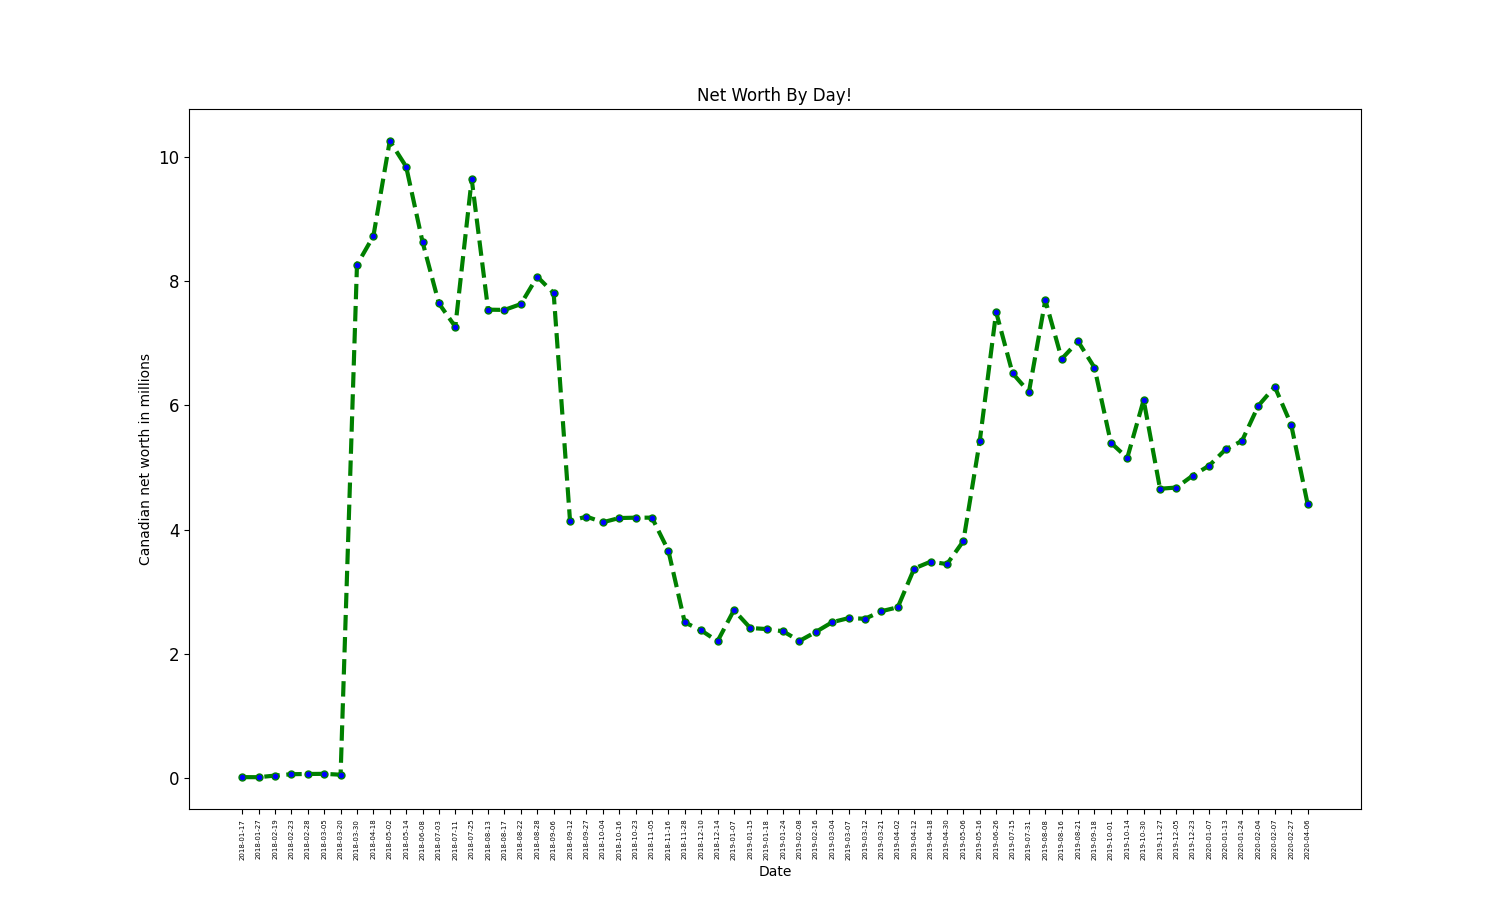